In [115]:
import ast
import glob
import json
import os
import re
import shutil
import traceback

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

In [2]:
%cd /home/nassimb/workspace/uparis/m2/pfe/text-role-classification

/home/nassimb/workspace/uparis/m2/pfe/text-role-classification


In [3]:
create_icpr2022real = True
create_hf_datasets = True

# Training dataset

In [4]:
train_annot_folder_path = (
    "./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1.0/annotations_JSON"
)

# Recursively find all .json files
train_annot_paths = glob.glob(
    os.path.join(train_annot_folder_path, "**", "*.json"), recursive=True
)

len(train_annot_paths)

22923

In [5]:
train_annot_paths[0]

'./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1.0/annotations_JSON/map/PMC5664696___ijerph-14-01195-g002.json'

In [6]:
train_img_folder_path = "./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1.0/images"

# Recursively find all .json files
train_img_paths = glob.glob(
    os.path.join(train_img_folder_path, "**", "*.jpg"), recursive=True
)

len(train_img_paths)

22923

In [7]:
icpr2022_train = {
    "text": [],
    "role": [],
    "x0": [],
    "x1": [],
    "x2": [],
    "x3": [],
    "y0": [],
    "y1": [],
    "y2": [],
    "y3": [],
    "chart_type": [],
    "annot_file": [],
    "img": [],
}

try:
    for file_path in train_annot_paths:
        with open(file_path, "r") as f:
            data = json.load(f)
            if data["task3"] and "task2_output" in data["task3"]["input"]:
                i = 0
                for text_block in data["task3"]["input"]["task2_output"]["text_blocks"]:
                    icpr2022_train["text"].append(text_block["text"])
                    icpr2022_train["role"].append(
                        data["task3"]["output"]["text_roles"][i]["role"]
                    )
                    icpr2022_train["x0"].append(text_block["polygon"]["x0"])
                    icpr2022_train["x1"].append(text_block["polygon"]["x1"])
                    icpr2022_train["x2"].append(text_block["polygon"]["x2"])
                    icpr2022_train["x3"].append(text_block["polygon"]["x3"])
                    icpr2022_train["y0"].append(text_block["polygon"]["y0"])
                    icpr2022_train["y1"].append(text_block["polygon"]["y1"])
                    icpr2022_train["y2"].append(text_block["polygon"]["y2"])
                    icpr2022_train["y3"].append(text_block["polygon"]["y3"])
                    icpr2022_train["chart_type"].append(
                        data["task1"]["output"]["chart_type"]
                    )
                    icpr2022_train["annot_file"].append(file_path)
                    pos_img = file_path.replace("annotations_JSON", "images").replace(
                        "json", "jpg"
                    )
                    if os.path.exists(pos_img):
                        icpr2022_train["img"].append(pos_img)
                    else:
                        icpr2022_train["img"].append(None)
                    i += 1

            else:
                icpr2022_train["text"].append(None)
                icpr2022_train["role"].append(None)
                icpr2022_train["x0"].append(None)
                icpr2022_train["x1"].append(None)
                icpr2022_train["x2"].append(None)
                icpr2022_train["x3"].append(None)
                icpr2022_train["y0"].append(None)
                icpr2022_train["y1"].append(None)
                icpr2022_train["y2"].append(None)
                icpr2022_train["y3"].append(None)
                icpr2022_train["chart_type"].append(
                    data["task1"]["output"]["chart_type"]
                )
                icpr2022_train["annot_file"].append(file_path)
                pos_img = file_path.replace("annotations_JSON", "images").replace(
                    "json", "jpg"
                )
                if os.path.exists(pos_img):
                    icpr2022_train["img"].append(pos_img)
                else:
                    icpr2022_train["img"].append(None)

except Exception as e:
    print(e, file_path)

In [8]:
df_icpr2022_train = pd.DataFrame(icpr2022_train)
df_icpr2022_train.head()

,text,role,x0,x1,x2,x3,y0,y1,y2,y3,chart_type,annot_file,img
0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,map,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....
1,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,map,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....
2,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,map,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....
3,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,map,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....
4,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,map,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....


In [9]:
df_icpr2022_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152239 entries, 0 to 152238
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   text        135786 non-null  object 
 1   role        135786 non-null  object 
 2   x0          135786 non-null  float64
 3   x1          135786 non-null  float64
 4   x2          135786 non-null  float64
 5   x3          135786 non-null  float64
 6   y0          135786 non-null  float64
 7   y1          135786 non-null  float64
 8   y2          135786 non-null  float64
 9   y3          135786 non-null  float64
 10  chart_type  152239 non-null  object 
 11  annot_file  152239 non-null  object 
 12  img         152239 non-null  object 
dtypes: float64(8), object(5)
memory usage: 15.1+ MB


In [10]:
df_icpr2022_train.describe()

,x0,x1,x2,x3,y0,y1,y2,y3
count,135786.000000,135786.000000,135786.000000,135786.000000,135786.000000,135786.000000,135786.000000,135786.000000
mean,230.602875,275.297674,275.554225,230.864588,266.750983,265.648624,289.687987,290.785015
std,210.314113,220.154078,220.254210,210.408102,170.030602,169.318724,168.837033,169.477240
min,-4.000000,6.000000,6.000000,-3.000000,-8.000000,-5.000000,2.000000,6.000000
25%,46.000000,76.000000,76.000000,46.000000,127.000000,127.000000,157.000000,157.000000
50%,164.000000,220.000000,221.000000,165.000000,260.000000,259.000000,286.000000,288.000000
75%,387.000000,447.000000,448.000000,387.000000,389.000000,387.000000,408.000000,409.000000
max,2737.000000,2870.000000,2870.000000,2737.000000,2138.000000,2138.000000,2223.000000,2223.000000


In [11]:
df_icpr2022_train.isnull().sum()

text          16453
role          16453
x0            16453
x1            16453
x2            16453
x3            16453
y0            16453
y1            16453
y2            16453
y3            16453
chart_type        0
annot_file        0
img               0
dtype: int64

In [12]:
df_icpr2022_train["role"].value_counts()

role
tick_label       95430
legend_label     12286
axis_title       10721
value_label       7649
other             6305
mark_label        1920
tick_grouping      792
chart_title        493
legend_title       190
Name: count, dtype: int64

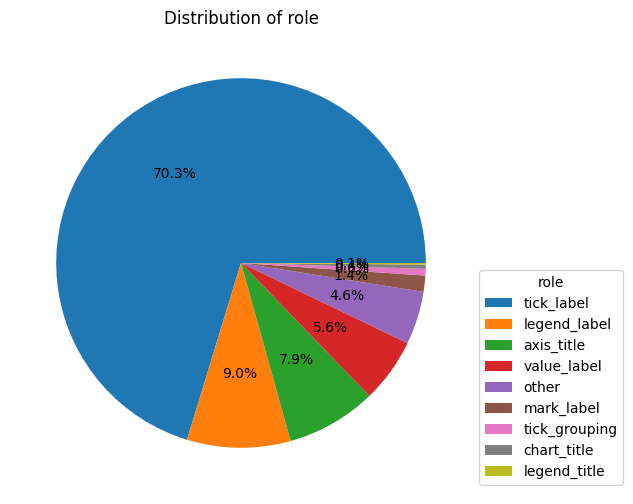

In [13]:
counts = df_icpr2022_train["role"].value_counts()
ax = counts.plot.pie(autopct="%1.1f%%", figsize=(6, 6), labels=[""] * len(counts))
plt.legend(ax.patches, counts.index, title="role", bbox_to_anchor=(1, 0.5))
plt.ylabel("")
plt.title("Distribution of role")
plt.show()

In [14]:
df_icpr2022_train["chart_type"].value_counts()

chart_type
line                   55118
vertical bar           43685
scatter                19553
horizontal bar         19238
vertical box            9356
scatter-line            3038
map                      533
vertical interval        532
pie                      242
heatmap                  197
manhattan                176
area                     172
horizontal interval      169
surface                  155
venn                      75
Name: count, dtype: int64

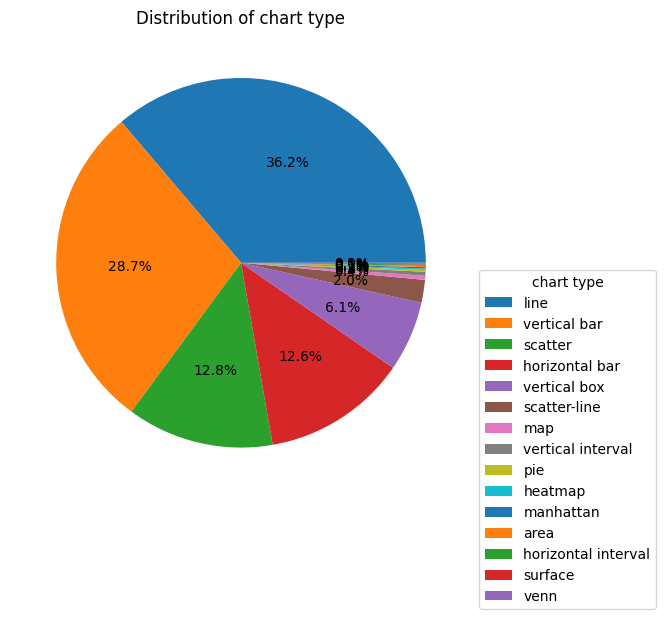

In [15]:
counts = df_icpr2022_train["chart_type"].value_counts()
ax = counts.plot.pie(autopct="%1.1f%%", figsize=(6, 6), labels=[""] * len(counts))
plt.legend(ax.patches, counts.index, title="chart type", bbox_to_anchor=(1, 0.5))
plt.ylabel("")
plt.title("Distribution of chart type")
plt.show()

In [16]:
df_icpr2022_train[df_icpr2022_train["role"].notnull()]["chart_type"].value_counts()

chart_type
line                   46798
vertical bar           40130
horizontal bar         19183
scatter                19134
vertical box            9194
scatter-line            1287
vertical interval         46
horizontal interval       14
Name: count, dtype: int64

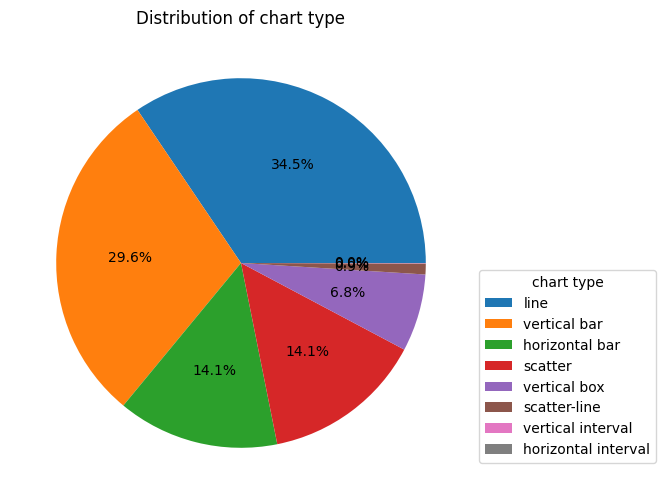

In [17]:
counts = df_icpr2022_train[df_icpr2022_train["role"].notnull()][
    "chart_type"
].value_counts()
ax = counts.plot.pie(autopct="%1.1f%%", figsize=(6, 6), labels=[""] * len(counts))
plt.legend(ax.patches, counts.index, title="chart type", bbox_to_anchor=(1, 0.5))
plt.ylabel("")
plt.title("Distribution of chart type")
plt.show()

In [18]:
df_icpr2022_train.nunique()

text          42048
role              9
x0              853
x1              867
x2              868
x3              852
y0              992
y1              985
y2             1012
y3             1015
chart_type       15
annot_file    22923
img           22923
dtype: int64

In [19]:
df_icpr2022_train[df_icpr2022_train["role"].notnull()].nunique()

text          42048
role              9
x0              853
x1              867
x2              868
x3              852
y0              992
y1              985
y2             1012
y3             1015
chart_type        8
annot_file     6470
img            6470
dtype: int64

In [20]:
df_icpr2022_train[df_icpr2022_train["role"].notnull()].head()

,text,role,x0,x1,x2,x3,y0,y1,y2,y3,chart_type,annot_file,img
534,Group,axis_title,372.0,432.0,432.0,372.0,430.0,430.0,453.0,453.0,scatter,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....
535,BCP/Hyaluronic,tick_label,578.0,702.0,702.0,578.0,401.0,401.0,422.0,422.0,scatter,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....
536,BCP/CMC-crosslink,tick_label,407.0,563.0,563.0,407.0,401.0,401.0,418.0,418.0,scatter,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....
537,BCP/CMC,tick_label,291.0,372.0,372.0,291.0,401.0,401.0,418.0,418.0,scatter,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....
538,BCP(control),tick_label,127.0,227.0,227.0,127.0,399.0,399.0,422.0,422.0,scatter,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....,./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1....


In [21]:
random_img_path = (
    df_icpr2022_train[
        df_icpr2022_train["role"].notnull()
        & (df_icpr2022_train["chart_type"] == "horizontal interval")
    ]["img"]
    .sample(1)
    .values[0]
)
# random_img_path = "./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1.0/images/line/PMC5615651___materials-10-00996-g007.jpg"

print(random_img_path)

img = cv2.imread(random_img_path)

labeled_polygons = []

for idx, row in df_icpr2022_train[
    df_icpr2022_train["img"] == random_img_path
].iterrows():
    labeled_polygons.append(
        (
            [
                (row["x0"], row["y0"]),
                (row["x1"], row["y1"]),
                (row["x2"], row["y2"]),
                (row["x3"], row["y3"]),
            ],
            row["role"],
        )
    )

font = cv2.FONT_HERSHEY_SIMPLEX
color = (0, 0, 255)
thikness = 1
scale = 0.5

for points, label in labeled_polygons:
    pts_arr = np.array(points, np.int32).reshape((-1, 1, 2))
    cv2.polylines(img, [pts_arr], isClosed=True, color=color, thickness=thikness)
    # Draw label near the first point
    cv2.putText(
        img,
        label,
        (int(points[0][0]), int(points[0][1]) - 5),
        font,
        scale,
        color,
        thikness,
    )

cv2.imwrite(f"./datasets/examples/annot_{random_img_path.replace('/', '_')}", img)

./datasets/ICPR2022_CHARTINFO_UB_PMC_TRAIN_v1.0/images/horizontal_interval/PMC5455512___materials-08-05138-g007.jpg


True

In [22]:
train_out_dir = "./datasets/_ICPR2022Real/train"
os.makedirs(f"{train_out_dir}/annotations", exist_ok=True)
os.makedirs(f"{train_out_dir}/images", exist_ok=True)

In [23]:
try:
    if not create_icpr2022real:
        raise Exception("create_icpr2022real set to False")

    for file_path in train_annot_paths:
        file_name = os.path.basename(file_path)
        with open(file_path, "r") as f:
            data = json.load(f)
            if data["task3"] and "task2_output" in data["task3"]["input"]:
                i = 0
                for text_block in data["task3"]["input"]["task2_output"]["text_blocks"]:
                    text_block["polygon"]["x0"] = max(0, text_block["polygon"]["x0"])
                    text_block["polygon"]["x1"] = max(0, text_block["polygon"]["x1"])
                    text_block["polygon"]["x2"] = max(0, text_block["polygon"]["x2"])
                    text_block["polygon"]["x3"] = max(0, text_block["polygon"]["x3"])
                    text_block["polygon"]["y0"] = max(0, text_block["polygon"]["y0"])
                    text_block["polygon"]["y1"] = max(0, text_block["polygon"]["y1"])
                    text_block["polygon"]["y2"] = max(0, text_block["polygon"]["y2"])
                    text_block["polygon"]["y3"] = max(0, text_block["polygon"]["y3"])
                with open(f"{train_out_dir}/annotations/{file_name}", "w") as f:
                    json.dump(data, f)
                    img = file_path.replace("annotations_JSON", "images").replace(
                        "json", "jpg"
                    )
                    shutil.copy(
                        img,
                        f"{train_out_dir}/images/{file_name.replace('json', 'jpg')}",
                    )

except Exception:
    if create_icpr2022real:
        print(file_path)
    traceback.print_exc()

In [24]:
train_hf_out_dir = "./datasets/ICPR2022Real_hf/train"
os.makedirs(f"{train_hf_out_dir}/images", exist_ok=True)

max_files_per_dir = 5000

In [25]:
try:
    if not create_hf_datasets:
        raise Exception("create_hf_datasets set to False")

    img_split_lookup = {}

    for idx, img in enumerate(df_icpr2022_train["img"].unique()):
        img_split_lookup[img] = idx // max_files_per_dir
        os.makedirs(
            f"{train_hf_out_dir}/images/split_{idx//max_files_per_dir}", exist_ok=True
        )
        shutil.copy(
            img,
            f"{train_hf_out_dir}/images/split_{idx//max_files_per_dir}/{os.path.basename(img)}",
        )

    df_icpr2022_train_hf = df_icpr2022_train.copy()
    df_icpr2022_train_hf["file_name"] = df_icpr2022_train_hf["img"].apply(
        lambda v: f"images/split_{img_split_lookup[v]}/{os.path.basename(v)}"
    )

    df_icpr2022_train_hf = df_icpr2022_train_hf.drop(columns=["img"])
    df_icpr2022_train_hf = df_icpr2022_train_hf.drop(columns=["annot_file"])

    df_icpr2022_train_hf.to_csv(f"{train_hf_out_dir}/metadata.csv", index=False)

except Exception:
    traceback.print_exc()

# Test dataset

## ICPR2022

In [26]:
icpr2022_test_annot_folder_path = (
    "./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TEST_v2.1/final_full_GT"
)

# Recursively find all .json files
icpr2022_test_annot_paths = glob.glob(
    os.path.join(icpr2022_test_annot_folder_path, "**", "annotations_JSON", "*.json"),
    recursive=True,
)

len(icpr2022_test_annot_paths)

13259

In [27]:
icpr2022_test_annot_paths[0]

'./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TEST_v2.1/final_full_GT/split_1/annotations_JSON/PMC6428810___1_HTML.json'

In [28]:
icpr2022_test_img_folder_path = (
    "./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TEST_v2.1/chart_images"
)

# Recursively find all .json files
icpr2022_test_img_paths = glob.glob(
    os.path.join(icpr2022_test_img_folder_path, "**", "images", "*.jpg"), recursive=True
)

len(icpr2022_test_img_paths)

13259

In [29]:
icpr2022_test = {
    "text": [],
    "role": [],
    "x0": [],
    "x1": [],
    "x2": [],
    "x3": [],
    "y0": [],
    "y1": [],
    "y2": [],
    "y3": [],
    "chart_type": [],
    "annot_file": [],
    "img": [],
}

try:
    for file_path in icpr2022_test_annot_paths:
        with open(file_path, "r") as f:
            data = json.load(f)
            if data["task3"] and "task2_output" in data["task3"]["input"]:
                i = 0
                for text_block in data["task3"]["input"]["task2_output"]["text_blocks"]:
                    icpr2022_test["text"].append(text_block["text"])
                    icpr2022_test["role"].append(
                        data["task3"]["output"]["text_roles"][i]["role"]
                    )
                    icpr2022_test["x0"].append(text_block["polygon"]["x0"])
                    icpr2022_test["x1"].append(text_block["polygon"]["x1"])
                    icpr2022_test["x2"].append(text_block["polygon"]["x2"])
                    icpr2022_test["x3"].append(text_block["polygon"]["x3"])
                    icpr2022_test["y0"].append(text_block["polygon"]["y0"])
                    icpr2022_test["y1"].append(text_block["polygon"]["y1"])
                    icpr2022_test["y2"].append(text_block["polygon"]["y2"])
                    icpr2022_test["y3"].append(text_block["polygon"]["y3"])
                    icpr2022_test["chart_type"].append(
                        data["task1"]["output"]["chart_type"]
                    )
                    icpr2022_test["annot_file"].append(file_path)
                    pos_img = (
                        file_path.replace("final_full_GT", "chart_images")
                        .replace("annotations_JSON", "images")
                        .replace("json", "jpg")
                    )
                    if os.path.exists(pos_img):
                        icpr2022_test["img"].append(pos_img)
                    else:
                        icpr2022_test["img"].append(None)
                    i += 1

            else:
                icpr2022_test["text"].append(None)
                icpr2022_test["role"].append(None)
                icpr2022_test["x0"].append(None)
                icpr2022_test["x1"].append(None)
                icpr2022_test["x2"].append(None)
                icpr2022_test["x3"].append(None)
                icpr2022_test["y0"].append(None)
                icpr2022_test["y1"].append(None)
                icpr2022_test["y2"].append(None)
                icpr2022_test["y3"].append(None)
                icpr2022_test["chart_type"].append(
                    data["task1"]["output"]["chart_type"]
                )
                icpr2022_test["annot_file"].append(file_path)
                pos_img = (
                    file_path.replace("final_full_GT", "chart_images")
                    .replace("annotations_JSON", "images")
                    .replace("json", "jpg")
                )
                if os.path.exists(pos_img):
                    icpr2022_test["img"].append(pos_img)
                else:
                    icpr2022_test["img"].append(None)

except Exception as e:
    print(e, file_path)

In [30]:
df_icpr2022_test = pd.DataFrame(icpr2022_test)
df_icpr2022_test.head()

,text,role,x0,x1,x2,x3,y0,y1,y2,y3,chart_type,annot_file,img
0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,line,./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TE...,./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TE...
1,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,vertical bar,./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TE...,./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TE...
2,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,horizontal bar,./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TE...,./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TE...
3,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,horizontal bar,./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TE...,./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TE...
4,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,scatter-line,./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TE...,./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TE...


In [31]:
df_icpr2022_test["split"] = df_icpr2022_test["annot_file"].str.extract(r"/(split_\d+)/")

In [32]:
df_icpr2022_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52040 entries, 0 to 52039
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   text        40654 non-null  object 
 1   role        40654 non-null  object 
 2   x0          40654 non-null  float64
 3   x1          40654 non-null  float64
 4   x2          40654 non-null  float64
 5   x3          40654 non-null  float64
 6   y0          40654 non-null  float64
 7   y1          40654 non-null  float64
 8   y2          40654 non-null  float64
 9   y3          40654 non-null  float64
 10  chart_type  52040 non-null  object 
 11  annot_file  52040 non-null  object 
 12  img         52040 non-null  object 
 13  split       52040 non-null  object 
dtypes: float64(8), object(6)
memory usage: 5.6+ MB


In [33]:
df_icpr2022_test.describe()

,x0,x1,x2,x3,y0,y1,y2,y3
count,40654.000000,40654.000000,40654.000000,40654.000000,40654.000000,40654.000000,40654.000000,40654.000000
mean,241.306440,287.360875,287.770035,241.716338,281.210090,279.153097,302.914695,304.968343
std,217.287315,226.768200,226.935584,217.434362,179.728169,178.180529,177.315521,178.740717
min,-5.000000,7.000000,7.000000,-2.000000,-1.000000,-5.000000,6.000000,6.000000
25%,44.000000,74.000000,74.000000,44.000000,131.000000,131.000000,161.000000,161.000000
50%,178.000000,242.000000,243.000000,179.000000,278.000000,276.000000,302.000000,304.000000
75%,408.000000,466.000000,466.000000,408.000000,414.000000,409.000000,430.000000,434.000000
max,2090.000000,2186.000000,2186.000000,2090.000000,1521.000000,1521.000000,1540.000000,1540.000000


In [34]:
df_icpr2022_test.isnull().sum()

text          11386
role          11386
x0            11386
x1            11386
x2            11386
x3            11386
y0            11386
y1            11386
y2            11386
y3            11386
chart_type        0
annot_file        0
img               0
split             0
dtype: int64

In [35]:
df_icpr2022_test["role"].value_counts()

role
tick_label       28032
legend_label      3888
axis_title        3022
other             2741
value_label       1575
mark_label         764
tick_grouping      290
chart_title        226
legend_title       116
Name: count, dtype: int64

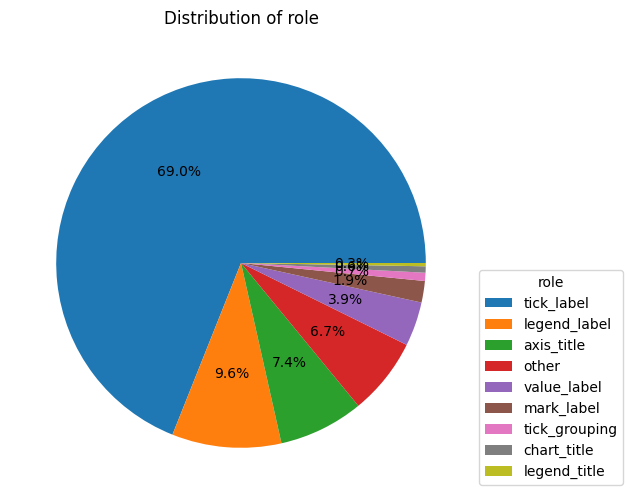

In [36]:
counts = df_icpr2022_test["role"].value_counts()
ax = counts.plot.pie(autopct="%1.1f%%", figsize=(6, 6), labels=[""] * len(counts))
plt.legend(ax.patches, counts.index, title="role", bbox_to_anchor=(1, 0.5))
plt.ylabel("")
plt.title("Distribution of role")
plt.show()

In [37]:
df_icpr2022_test["chart_type"].value_counts()

chart_type
line                   15864
vertical bar           15641
scatter                 7426
horizontal bar          5943
vertical box            3661
scatter-line            1674
horizontal interval      430
map                      373
pie                      191
vertical interval        182
heatmap                  180
area                     136
venn                     131
surface                  128
manhattan                 80
Name: count, dtype: int64

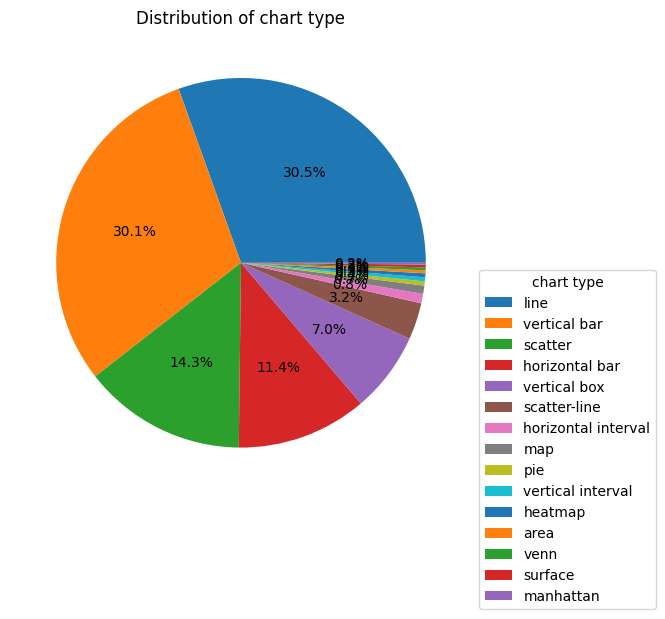

In [38]:
counts = df_icpr2022_test["chart_type"].value_counts()
ax = counts.plot.pie(autopct="%1.1f%%", figsize=(6, 6), labels=[""] * len(counts))
plt.legend(ax.patches, counts.index, title="chart type", bbox_to_anchor=(1, 0.5))
plt.ylabel("")
plt.title("Distribution of chart type")
plt.show()

In [39]:
df_icpr2022_test[df_icpr2022_test["role"].notnull()]["chart_type"].value_counts()

chart_type
line              13088
vertical bar      12458
scatter            6477
horizontal bar     5518
vertical box       3065
scatter-line         48
Name: count, dtype: int64

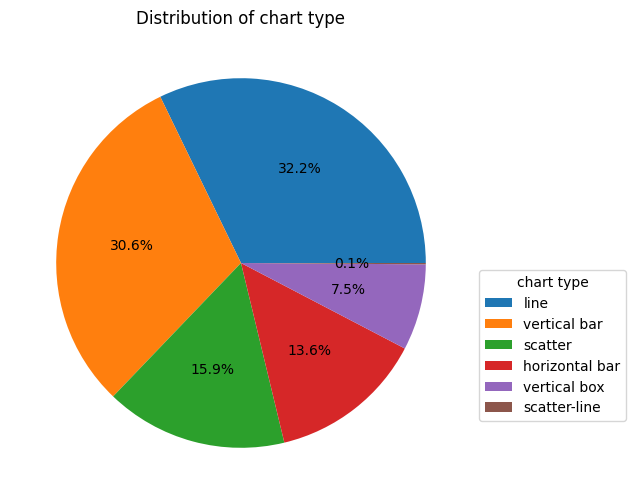

In [40]:
counts = df_icpr2022_test[df_icpr2022_test["role"].notnull()][
    "chart_type"
].value_counts()
ax = counts.plot.pie(autopct="%1.1f%%", figsize=(6, 6), labels=[""] * len(counts))
plt.legend(ax.patches, counts.index, title="chart type", bbox_to_anchor=(1, 0.5))
plt.ylabel("")
plt.title("Distribution of chart type")
plt.show()

In [41]:
df_icpr2022_test["split"].value_counts()

split
split_2    13243
split_1    11434
split_4     9969
split_5     9235
split_3     8159
Name: count, dtype: int64

In [42]:
df_icpr2022_test[df_icpr2022_test["role"].notnull()]["split"].value_counts()

split
split_2    13243
split_4     9969
split_5     9235
split_3     8159
split_1       48
Name: count, dtype: int64

In [43]:
df_icpr2022_test.nunique()

text          15314
role              9
x0              822
x1              844
x2              841
x3              821
y0              868
y1              858
y2              888
y3              901
chart_type       15
annot_file    13259
img           13259
split             5
dtype: int64

In [44]:
df_icpr2022_test[df_icpr2022_test["role"].notnull()].nunique()

text          15314
role              9
x0              822
x1              844
x2              841
x3              821
y0              868
y1              858
y2              888
y3              901
chart_type        6
annot_file     1873
img            1873
split             5
dtype: int64

In [45]:
random_img_path = (
    df_icpr2022_test[df_icpr2022_test["role"].notnull()]["img"].sample(1).values[0]
)
# random_img_path = "./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TEST_v2.1/chart_images/split_2/images/PMC6404038___2.jpg"

print(random_img_path)

img = cv2.imread(random_img_path)

labeled_polygons = []

for idx, row in df_icpr2022_test[df_icpr2022_test["img"] == random_img_path].iterrows():
    labeled_polygons.append(
        (
            [
                (row["x0"], row["y0"]),
                (row["x1"], row["y1"]),
                (row["x2"], row["y2"]),
                (row["x3"], row["y3"]),
            ],
            row["role"],
        )
    )

font = cv2.FONT_HERSHEY_SIMPLEX
color = (0, 0, 255)
thikness = 1
scale = 0.5

for points, label in labeled_polygons:
    pts_arr = np.array(points, np.int32).reshape((-1, 1, 2))
    cv2.polylines(img, [pts_arr], isClosed=True, color=color, thickness=thikness)
    # Draw label near the first point
    cv2.putText(
        img,
        label,
        (int(points[0][0]), int(points[0][1]) - 5),
        font,
        scale,
        color,
        thikness,
    )

cv2.imwrite(f"./datasets/examples/annot_{random_img_path.replace('/', '_')}", img)

./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TEST_v2.1/chart_images/split_2/images/PMC5951842___10_HTML.jpg


True

In [46]:
test_out_dir = "./datasets/_ICPR2022Real/test"
os.makedirs(f"{test_out_dir}/annotations", exist_ok=True)
os.makedirs(f"{test_out_dir}/images", exist_ok=True)

In [47]:
try:
    if not create_icpr2022real:
        raise Exception("create_icpr2022real set to False")

    for file_path in icpr2022_test_annot_paths:
        file_name = os.path.basename(file_path)
        with open(file_path, "r") as f:
            data = json.load(f)
            if data["task3"] and "task2_output" in data["task3"]["input"]:
                i = 0
                for text_block in data["task3"]["input"]["task2_output"]["text_blocks"]:
                    text_block["polygon"]["x0"] = max(0, text_block["polygon"]["x0"])
                    text_block["polygon"]["x1"] = max(0, text_block["polygon"]["x1"])
                    text_block["polygon"]["x2"] = max(0, text_block["polygon"]["x2"])
                    text_block["polygon"]["x3"] = max(0, text_block["polygon"]["x3"])
                    text_block["polygon"]["y0"] = max(0, text_block["polygon"]["y0"])
                    text_block["polygon"]["y1"] = max(0, text_block["polygon"]["y1"])
                    text_block["polygon"]["y2"] = max(0, text_block["polygon"]["y2"])
                    text_block["polygon"]["y3"] = max(0, text_block["polygon"]["y3"])
                with open(f"{test_out_dir}/annotations/{file_name}", "w") as f:
                    json.dump(data, f)
                    img = (
                        file_path.replace("final_full_GT", "chart_images")
                        .replace("annotations_JSON", "images")
                        .replace("json", "jpg")
                    )

                    shutil.copy(
                        img,
                        f"{test_out_dir}/images/{file_name.replace('json', 'jpg')}",
                    )

except Exception:
    if create_icpr2022real:
        print(file_path)
    traceback.print_exc()

In [48]:
test_hf_out_dir = "./datasets/ICPR2022Real_hf/test"
os.makedirs(f"{test_hf_out_dir}/images", exist_ok=True)

In [49]:
try:
    if not create_hf_datasets:
        raise Exception("create_hf_datasets set to False")

    img_split_lookup = {}

    for idx, img in enumerate(df_icpr2022_test["img"].unique()):
        img_split_lookup[img] = idx // max_files_per_dir
        os.makedirs(
            f"{test_hf_out_dir}/images/split_{idx//max_files_per_dir}", exist_ok=True
        )
        shutil.copy(
            img,
            f"{test_hf_out_dir}/images/split_{idx//max_files_per_dir}/{os.path.basename(img)}",
        )

    df_icpr2022_test_hf = df_icpr2022_test.copy()
    df_icpr2022_test_hf["file_name"] = df_icpr2022_test_hf["img"].apply(
        lambda v: f"images/split_{img_split_lookup[v]}/{os.path.basename(v)}"
    )
    df_icpr2022_test_hf = df_icpr2022_test_hf.drop(columns=["img"])
    df_icpr2022_test_hf = df_icpr2022_test_hf.drop(columns=["annot_file"])

    df_icpr2022_test_hf.to_csv(f"{test_hf_out_dir}/metadata.csv", index=False)

except Exception:
    traceback.print_exc()

## EconBiz

In [50]:
econbiz_annot_folder_path = "./datasets/EconBiz"

# Recursively find all .json files
econbiz_annot_paths = glob.glob(
    os.path.join(econbiz_annot_folder_path, "**", "annotations", "*.json"),
    recursive=True,
)

len(econbiz_annot_paths)

121

In [51]:
econbiz_annot_paths[0]

'./datasets/EconBiz/train/annotations/10008831881-008.json'

In [52]:
econbiz_img_folder_path = "./datasets/EconBiz"

# Recursively find all .json files
econbiz_img_paths = glob.glob(
    os.path.join(econbiz_img_folder_path, "**", "images", "*.png"), recursive=True
)

len(econbiz_img_paths)

121

In [53]:
econbiz = {
    "text": [],
    "role": [],
    "center_x": [],
    "center_y": [],
    "width": [],
    "height": [],
    "orientation": [],
    "annot_file": [],
    "img": [],
    "split": [],
}

try:
    for file_path in econbiz_annot_paths:
        with open(file_path, "r") as f:
            data = json.load(f)
            for text_element in data["textelements"]:
                econbiz["text"].append(text_element["content"])
                econbiz["role"].append(text_element["role"])
                econbiz["center_x"].append(text_element["boundingbox"]["center_x"])
                econbiz["center_y"].append(text_element["boundingbox"]["center_y"])
                econbiz["width"].append(text_element["boundingbox"]["width"])
                econbiz["height"].append(text_element["boundingbox"]["height"])
                econbiz["orientation"].append(
                    text_element["boundingbox"]["orientation"]
                )
                econbiz["annot_file"].append(file_path)
                econbiz["img"].append(
                    file_path.replace("annotations", "images").replace("json", "png")
                )
                if "test" in os.path.normpath(file_path).split(os.sep):
                    econbiz["split"].append("test")
                else:
                    econbiz["split"].append("train")

except Exception as e:
    print(e, file_path)

In [54]:
df_econbiz = pd.DataFrame(econbiz)
df_econbiz.head()

,text,role,center_x,center_y,width,height,orientation,annot_file,img,split
0,ψ,other,237,98,28,30,0,./datasets/EconBiz/train/annotations/100088318...,./datasets/EconBiz/train/images/10008831881-00...,train
1,ψ,other,426,499,28,30,0,./datasets/EconBiz/train/annotations/100088318...,./datasets/EconBiz/train/images/10008831881-00...,train
2,5' LTR,other,119,113,90,30,0,./datasets/EconBiz/train/annotations/100088318...,./datasets/EconBiz/train/images/10008831881-00...,train
3,5' LTR,other,357,516,90,30,0,./datasets/EconBiz/train/annotations/100088318...,./datasets/EconBiz/train/images/10008831881-00...,train
4,ORF,other,673,516,62,29,0,./datasets/EconBiz/train/annotations/100088318...,./datasets/EconBiz/train/images/10008831881-00...,train


In [55]:
df_econbiz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3057 entries, 0 to 3056
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         3057 non-null   object
 1   role         3057 non-null   object
 2   center_x     3057 non-null   int64 
 3   center_y     3057 non-null   int64 
 4   width        3057 non-null   int64 
 5   height       3057 non-null   int64 
 6   orientation  3057 non-null   int64 
 7   annot_file   3057 non-null   object
 8   img          3057 non-null   object
 9   split        3057 non-null   object
dtypes: int64(5), object(5)
memory usage: 239.0+ KB


In [56]:
df_econbiz.describe()

,center_x,center_y,width,height,orientation
count,3057.000000,3057.000000,3057.000000,3057.000000,3057.000000
mean,413.217206,408.154727,69.338240,22.710173,-12.906444
std,326.420953,215.973175,85.088652,6.692361,34.421411
min,12.000000,9.000000,10.000000,10.000000,-270.000000
25%,116.000000,237.000000,27.000000,18.000000,0.000000
50%,362.000000,427.000000,43.000000,21.000000,0.000000
75%,627.000000,556.000000,78.000000,26.000000,0.000000
max,1849.000000,1122.000000,1046.000000,54.000000,270.000000


In [57]:
df_econbiz.isnull().sum()

text           0
role           0
center_x       0
center_y       0
width          0
height         0
orientation    0
annot_file     0
img            0
split          0
dtype: int64

In [58]:
df_econbiz["role"].value_counts()

role
tick_label       1805
other             440
legend_label      258
value_label       175
mark_label        175
axis_title        125
chart_title        36
tick_grouping      36
legend_title        7
Name: count, dtype: int64

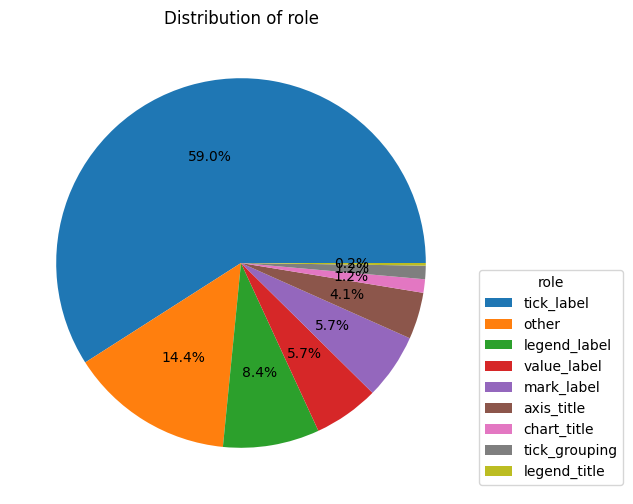

In [59]:
counts = df_econbiz["role"].value_counts()
ax = counts.plot.pie(autopct="%1.1f%%", figsize=(6, 6), labels=[""] * len(counts))
plt.legend(ax.patches, counts.index, title="role", bbox_to_anchor=(1, 0.5))
plt.ylabel("")
plt.title("Distribution of role")
plt.show()

In [60]:
df_econbiz["split"].value_counts()

split
train    2134
test      923
Name: count, dtype: int64

In [61]:
df_econbiz.nunique()

text           1780
role              9
center_x        971
center_y        783
width           300
height           42
orientation      18
annot_file      121
img             121
split             2
dtype: int64

In [62]:
df_econbiz[df_econbiz["role"].notnull()].nunique()

text           1780
role              9
center_x        971
center_y        783
width           300
height           42
orientation      18
annot_file      121
img             121
split             2
dtype: int64

In [63]:
random_img_path = df_econbiz[df_econbiz["role"].notnull()]["img"].sample(1).values[0]
# random_img_path = "./datasets/EconBiz/train/images/10009328051-017.png"

print(random_img_path)

img = cv2.imread(random_img_path)

labeled_polygons = []

for idx, row in df_econbiz[df_econbiz["img"] == random_img_path].iterrows():
    rect = (
        (row["center_x"], row["center_y"]),
        (row["width"], row["height"]),
        row["orientation"],
    )
    points = cv2.boxPoints(rect)  # returns float32
    labeled_polygons.append((points.astype(int), row["role"]))

font = cv2.FONT_HERSHEY_SIMPLEX
color = (0, 0, 255)
thikness = 1
scale = 0.5

for points, label in labeled_polygons:
    cv2.polylines(img, [points], isClosed=True, color=color, thickness=thikness)
    # Draw label near the first point
    cv2.putText(
        img,
        label,
        (points[0, 0], points[0, 1] + 15),
        font,
        scale,
        color,
        thikness,
    )
cv2.imwrite(f"./datasets/examples/annot_{random_img_path.replace('/', '_')}", img)

./datasets/EconBiz/train/images/10008480575-001.png


True

In [64]:
econbiz_test_hf_out_dir = "./datasets/EconBiz_hf/test"
os.makedirs(f"{econbiz_test_hf_out_dir}/images", exist_ok=True)

In [65]:
try:
    if not create_hf_datasets:
        raise Exception("create_hf_datasets set to False")

    for img in df_econbiz[df_econbiz["split"] == "test"]["img"].unique():
        shutil.copy(
            img,
            f"{econbiz_test_hf_out_dir}/images/{os.path.basename(img)}",
        )

    df_econbiz_test_hf = df_econbiz[df_econbiz["split"] == "test"].copy()
    df_econbiz_test_hf["file_name"] = df_econbiz_test_hf["img"].apply(
        lambda v: f"images/{os.path.basename(v)}"
    )
    df_econbiz_test_hf = df_econbiz_test_hf.drop(columns=["img"])
    df_econbiz_test_hf = df_econbiz_test_hf.drop(columns=["annot_file"])
    df_econbiz_test_hf = df_econbiz_test_hf.drop(columns=["split"])

    df_econbiz_test_hf.to_csv(f"{econbiz_test_hf_out_dir}/metadata.csv", index=False)

except Exception:
    traceback.print_exc()

In [66]:
econbiz_train_hf_out_dir = "./datasets/EconBiz_hf/train"
os.makedirs(f"{econbiz_train_hf_out_dir}/images", exist_ok=True)

In [67]:
try:
    if not create_hf_datasets:
        raise Exception("create_hf_datasets set to False")

    for img in df_econbiz[df_econbiz["split"] == "train"]["img"].unique():
        shutil.copy(
            img,
            f"{econbiz_train_hf_out_dir}/images/{os.path.basename(img)}",
        )

    df_econbiz_train_hf = df_econbiz[df_econbiz["split"] == "train"].copy()

    df_econbiz_train_hf["file_name"] = df_econbiz_train_hf["img"].apply(
        lambda v: f"images/{os.path.basename(v)}"
    )

    df_econbiz_train_hf = df_econbiz_train_hf.drop(columns=["img"])
    df_econbiz_train_hf = df_econbiz_train_hf.drop(columns=["annot_file"])
    df_econbiz_train_hf = df_econbiz_train_hf.drop(columns=["split"])

    df_econbiz_train_hf.to_csv(f"{econbiz_train_hf_out_dir}/metadata.csv", index=False)

except Exception:
    traceback.print_exc()

## CHIMIE-R

In [68]:
chimie_r_annot_folder_path = "./datasets/CHIME-R"

# Recursively find all .json files
chimie_r_annot_paths = glob.glob(
    os.path.join(chimie_r_annot_folder_path, "**", "annotations", "*.json"),
    recursive=True,
)

len(chimie_r_annot_paths)

115

In [69]:
chimie_r_annot_paths[0]

'./datasets/CHIME-R/train/annotations/dbar011.json'

In [70]:
chimie_r_img_folder_path = "./datasets/CHIME-R"

# Recursively find all .json files
chimie_r_img_paths = glob.glob(
    os.path.join(chimie_r_img_folder_path, "**", "images", "*.bmp"), recursive=True
)

len(chimie_r_img_paths)

115

In [71]:
chimie_r = {
    "text": [],
    "role": [],
    "center_x": [],
    "center_y": [],
    "width": [],
    "height": [],
    "orientation": [],
    "annot_file": [],
    "img": [],
    "chart_type": [],
    "split": [],
}

try:
    for file_path in chimie_r_annot_paths:
        with open(file_path, "r") as f:
            data = json.load(f)
            for text_element in data["textelements"]:
                chimie_r["text"].append(text_element["content"])
                chimie_r["role"].append(text_element["role"])
                chimie_r["center_x"].append(text_element["boundingbox"]["center_x"])
                chimie_r["center_y"].append(text_element["boundingbox"]["center_y"])
                chimie_r["width"].append(text_element["boundingbox"]["width"])
                chimie_r["height"].append(text_element["boundingbox"]["height"])
                chimie_r["orientation"].append(
                    text_element["boundingbox"]["orientation"]
                )
                chimie_r["annot_file"].append(file_path)
                chimie_r["img"].append(
                    file_path.replace("annotations", "images").replace("json", "bmp")
                )
                file_name = os.path.basename(file_path)
                chimie_r["chart_type"].append(re.match(r"^\D*", file_name).group())
                if "test" in os.path.normpath(file_path).split(os.sep):
                    chimie_r["split"].append("test")
                else:
                    chimie_r["split"].append("train")

except Exception as e:
    print(e, file_path)

In [72]:
df_chimie_r = pd.DataFrame(chimie_r)
df_chimie_r.head()

,text,role,center_x,center_y,width,height,orientation,annot_file,img,chart_type,split
0,Governors Challenge Goal 2,chart_title,331,32,282,19,0,./datasets/CHIME-R/train/annotations/dbar011.json,./datasets/CHIME-R/train/images/dbar011.bmp,dbar,train
1,"16,000,000",tick_label,88,121,78,15,0,./datasets/CHIME-R/train/annotations/dbar011.json,./datasets/CHIME-R/train/images/dbar011.bmp,dbar,train
2,"14,000,000",tick_label,88,148,78,15,0,./datasets/CHIME-R/train/annotations/dbar011.json,./datasets/CHIME-R/train/images/dbar011.bmp,dbar,train
3,"12,000,000",tick_label,88,175,78,15,0,./datasets/CHIME-R/train/annotations/dbar011.json,./datasets/CHIME-R/train/images/dbar011.bmp,dbar,train
4,"10,000,000",tick_label,88,202,78,15,0,./datasets/CHIME-R/train/annotations/dbar011.json,./datasets/CHIME-R/train/images/dbar011.bmp,dbar,train


In [73]:
df_chimie_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587 entries, 0 to 1586
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         1587 non-null   object
 1   role         1587 non-null   object
 2   center_x     1587 non-null   int64 
 3   center_y     1587 non-null   int64 
 4   width        1587 non-null   int64 
 5   height       1587 non-null   int64 
 6   orientation  1587 non-null   int64 
 7   annot_file   1587 non-null   object
 8   img          1587 non-null   object
 9   chart_type   1587 non-null   object
 10  split        1587 non-null   object
dtypes: int64(5), object(6)
memory usage: 136.5+ KB


In [74]:
df_chimie_r.isnull().sum()

text           0
role           0
center_x       0
center_y       0
width          0
height         0
orientation    0
annot_file     0
img            0
chart_type     0
split          0
dtype: int64

In [75]:
df_chimie_r["role"].value_counts()

role
tick_label       1183
axis_title        140
value_label       111
chart_title        67
legend_label       55
other              25
tick_grouping       5
legend_title        1
Name: count, dtype: int64

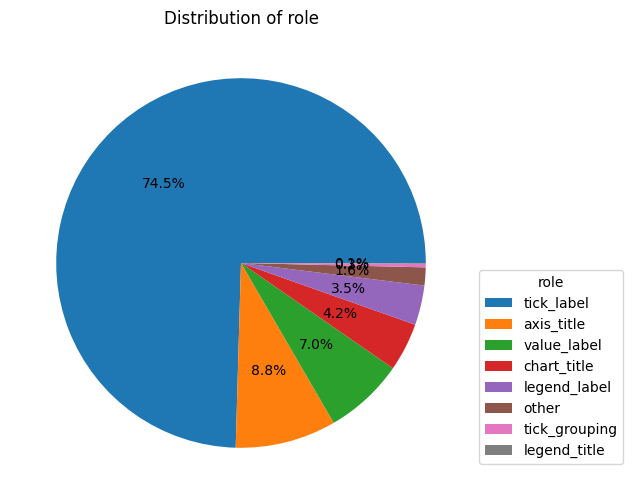

In [76]:
counts = df_chimie_r["role"].value_counts()
ax = counts.plot.pie(autopct="%1.1f%%", figsize=(6, 6), labels=[""] * len(counts))
plt.legend(ax.patches, counts.index, title="role", bbox_to_anchor=(1, 0.5))
plt.ylabel("")
plt.title("Distribution of role")
plt.show()

In [77]:
df_chimie_r["chart_type"].value_counts()

chart_type
bar      968
dbar     270
line     179
pie      150
dline     20
Name: count, dtype: int64

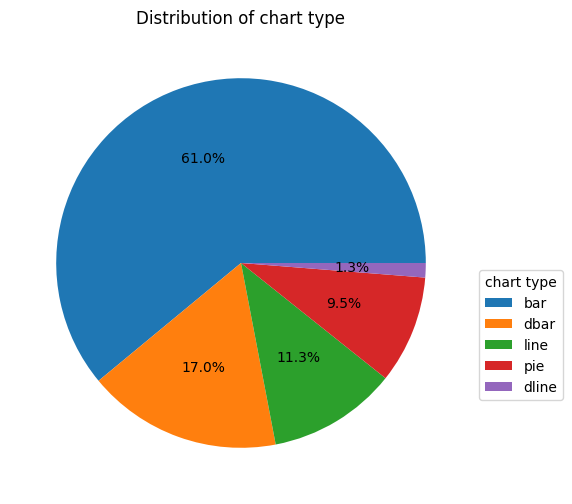

In [78]:
counts = df_chimie_r["chart_type"].value_counts()
ax = counts.plot.pie(autopct="%1.1f%%", figsize=(6, 6), labels=[""] * len(counts))
plt.legend(ax.patches, counts.index, title="chart type", bbox_to_anchor=(1, 0.5))
plt.ylabel("")
plt.title("Distribution of chart type")
plt.show()

In [79]:
df_chimie_r["split"].value_counts()

split
train    1090
test      497
Name: count, dtype: int64

In [80]:
df_chimie_r.nunique()

text           528
role             8
center_x       598
center_y       504
width          178
height          84
orientation      1
annot_file     115
img            115
chart_type       5
split            2
dtype: int64

In [81]:
df_chimie_r[df_chimie_r["role"].notnull()].nunique()

text           528
role             8
center_x       598
center_y       504
width          178
height          84
orientation      1
annot_file     115
img            115
chart_type       5
split            2
dtype: int64

In [82]:
df_chimie_r[df_chimie_r["split"] == "train"].nunique()

text           415
role             8
center_x       531
center_y       425
width          162
height          74
orientation      1
annot_file      80
img             80
chart_type       5
split            1
dtype: int64

In [83]:
random_img_path = df_chimie_r[df_chimie_r["role"].notnull()]["img"].sample(1).values[0]
# random_img_path = "./datasets/ICPR2022_CHARTINFO_UB_UNITEC_PMC_TEST_v2.1/chart_images/split_2/images/PMC6404038___2.jpg"

print(random_img_path)

img = cv2.imread(random_img_path)

labeled_polygons = []

for idx, row in df_chimie_r[df_chimie_r["img"] == random_img_path].iterrows():
    rect = (
        (row["center_x"], row["center_y"]),
        (row["width"], row["height"]),
        row["orientation"],
    )
    points = cv2.boxPoints(rect)  # returns float32
    labeled_polygons.append((points.astype(int), row["role"]))

font = cv2.FONT_HERSHEY_SIMPLEX
color = (0, 0, 255)
thikness = 1
scale = 0.5

for points, label in labeled_polygons:
    cv2.polylines(img, [points], isClosed=True, color=color, thickness=thikness)
    # Draw label near the first point
    cv2.putText(
        img,
        label,
        (points[0, 0], points[0, 1] + 15),
        font,
        scale,
        color,
        thikness,
    )
cv2.imwrite(f"./datasets/examples/annot_{random_img_path.replace('/', '_')}", img)

./datasets/CHIME-R/train/images/line012.bmp


True

In [84]:
chimie_r_test_hf_out_dir = "./datasets/CHIME-R_hf/test"
os.makedirs(f"{chimie_r_test_hf_out_dir}/images", exist_ok=True)

In [85]:
try:
    if not create_hf_datasets:
        raise Exception("create_hf_datasets set to False")

    for img in df_chimie_r[df_chimie_r["split"] == "test"]["img"].unique():
        shutil.copy(
            img,
            f"{chimie_r_test_hf_out_dir}/images/{os.path.basename(img)}",
        )

    df_chimie_r_test_hf = df_chimie_r[df_chimie_r["split"] == "test"].copy()
    df_chimie_r_test_hf["file_name"] = df_chimie_r_test_hf["img"].apply(
        lambda v: f"images/{os.path.basename(v)}"
    )
    df_chimie_r_test_hf = df_chimie_r_test_hf.drop(columns=["img"])
    df_chimie_r_test_hf = df_chimie_r_test_hf.drop(columns=["annot_file"])
    df_chimie_r_test_hf = df_chimie_r_test_hf.drop(columns=["split"])

    df_chimie_r_test_hf.to_csv(f"{chimie_r_test_hf_out_dir}/metadata.csv", index=False)

except Exception:
    traceback.print_exc()

In [86]:
chimie_r_train_hf_out_dir = "./datasets/CHIME-R_hf/train"
os.makedirs(f"{chimie_r_train_hf_out_dir}/images", exist_ok=True)

In [87]:
try:
    if not create_hf_datasets:
        raise Exception("create_hf_datasets set to False")

    for img in df_chimie_r[df_chimie_r["split"] == "train"]["img"].unique():
        shutil.copy(
            img,
            f"{chimie_r_train_hf_out_dir}/images/{os.path.basename(img)}",
        )

    df_chimie_r_train_hf = df_chimie_r[df_chimie_r["split"] == "train"].copy()
    df_chimie_r_train_hf["file_name"] = df_chimie_r_train_hf["img"].apply(
        lambda v: f"images/{os.path.basename(v)}"
    )
    df_chimie_r_train_hf = df_chimie_r_train_hf.drop(columns=["img"])
    df_chimie_r_train_hf = df_chimie_r_train_hf.drop(columns=["annot_file"])
    df_chimie_r_train_hf = df_chimie_r_train_hf.drop(columns=["split"])

    df_chimie_r_train_hf.to_csv(
        f"{chimie_r_train_hf_out_dir}/metadata.csv", index=False
    )

except Exception:
    traceback.print_exc()

# Connect to wandb

In [88]:
import wandb

api = wandb.Api(api_key="29d0d6a18093ce2fee4a6b00aca4efdc220a8a9d")
run = api.run("/nassimb0u-test/huggingface/runs/tj6nssvd")

print(run.history())

print(run.logged_artifacts())

    _step  eval/recall  train/epoch  eval/precision  train/loss    _timestamp  \
0       0     0.000000     1.842105        0.000000         NaN  1.749596e+09   
1       1          NaN     3.421053             NaN      1.3401  1.749596e+09   
2       2     0.000000     3.421053        0.000000         NaN  1.749596e+09   
3       3     0.114286     5.000000        0.090476         NaN  1.749596e+09   
4       4          NaN     6.842105             NaN      0.7653  1.749596e+09   
5       5     0.233333     6.842105        0.351190         NaN  1.749596e+09   
6       6     0.355102     8.421053        0.448980         NaN  1.749596e+09   
7       7          NaN    10.000000             NaN      0.4211  1.749596e+09   
8       8     0.424490    10.000000        0.476190         NaN  1.749596e+09   
9       9     0.493878    11.842105        0.479592         NaN  1.749596e+09   
10     10          NaN    13.421053             NaN      0.2856  1.749596e+09   
11     11     0.502041    13

# Eval/Test results

## icpr22

In [119]:
icpr22_preds = []
with open("./datasets/eval_test_results/predictions_icpr22.txt", "r") as f:
    for line in f:
        i, list_str = line.split(":", 1)
        items = ast.literal_eval(list_str.strip())
        icpr22_preds.extend(items)
print(len(icpr22_preds))

40656


In [120]:
df_icpr22_dataset_ordered_wpred = pd.read_csv(
    "./datasets/eval_test_results/icpr22_dataset_ordered_wpred.csv"
)
df_icpr22_dataset_ordered_wpred["predicted_role"] = icpr22_preds
df_icpr22_dataset_ordered_wpred.head()

,role,bbox,id,predicted_role
0,AXIS_TITLE,"[333, 961, 785, 997]",0,AXIS_TITLE
1,AXIS_TITLE,"[4, 235, 32, 604]",0,AXIS_TITLE
2,TICK_LABEL,"[268, 901, 287, 935]",0,TICK_LABEL
3,TICK_LABEL,"[404, 901, 443, 931]",0,TICK_LABEL
4,TICK_LABEL,"[545, 901, 584, 933]",0,TICK_LABEL


In [121]:
labels = df_icpr22_dataset_ordered_wpred["role"].unique()

In [122]:
df_icpr22_dataset_ordered_wpred["role"].value_counts()

role
TICK_LABEL       28032
LEGEND_LABEL      3890
AXIS_TITLE        3022
OTHER             2741
VALUE_LABEL       1575
MARK_LABEL         764
TICK_GROUPING      290
CHART_TITLE        226
LEGEND_TITLE       116
Name: count, dtype: int64

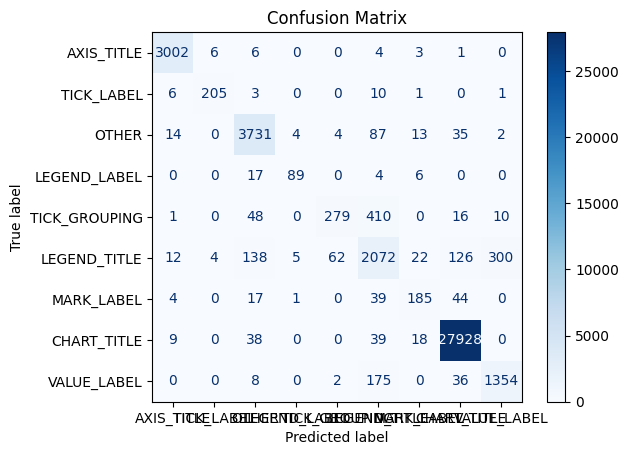

In [123]:
# Confusion Matrix
cm_icpr22 = confusion_matrix(
    df_icpr22_dataset_ordered_wpred["role"],
    df_icpr22_dataset_ordered_wpred["predicted_role"],
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_icpr22,
    display_labels=labels,
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

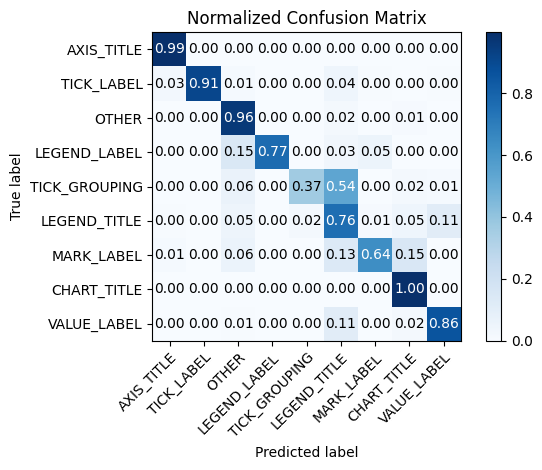

In [124]:
cm_icpr22_normalized = cm_icpr22.astype("float") / cm_icpr22.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
im = ax.imshow(cm_icpr22_normalized, interpolation="nearest", cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(cm_icpr22.shape[1]),
    yticks=np.arange(cm_icpr22.shape[0]),
    xticklabels=labels,
    yticklabels=labels,
    title="Normalized Confusion Matrix",
    ylabel="True label",
    xlabel="Predicted label",
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

fmt = ".2f"
thresh = cm_icpr22_normalized.max() / 2.0
for i in range(cm_icpr22.shape[0]):
    for j in range(cm_icpr22.shape[1]):
        ax.text(
            j,
            i,
            format(cm_icpr22_normalized[i, j], fmt),
            ha="center",
            va="center",
            color="white" if cm_icpr22_normalized[i, j] > thresh else "black",
        )
fig.tight_layout()
plt.show()

In [125]:
icpr22_accuracy = accuracy_score(
    df_icpr22_dataset_ordered_wpred["role"],
    df_icpr22_dataset_ordered_wpred["predicted_role"],
)
icpr22_precision_macro = precision_score(
    df_icpr22_dataset_ordered_wpred["role"],
    df_icpr22_dataset_ordered_wpred["predicted_role"],
    average="macro",
)
icpr22_precision_micro = precision_score(
    df_icpr22_dataset_ordered_wpred["role"],
    df_icpr22_dataset_ordered_wpred["predicted_role"],
    average="micro",
)
icpr22_recall_macro = recall_score(
    df_icpr22_dataset_ordered_wpred["role"],
    df_icpr22_dataset_ordered_wpred["predicted_role"],
    average="macro",
)
icpr22_recall_micro = recall_score(
    df_icpr22_dataset_ordered_wpred["role"],
    df_icpr22_dataset_ordered_wpred["predicted_role"],
    average="micro",
)
icpr22_f1_macro = f1_score(
    df_icpr22_dataset_ordered_wpred["role"],
    df_icpr22_dataset_ordered_wpred["predicted_role"],
    average="macro",
)
icpr22_f1_micro = f1_score(
    df_icpr22_dataset_ordered_wpred["role"],
    df_icpr22_dataset_ordered_wpred["predicted_role"],
    average="micro",
)

print("Accuracy:", icpr22_accuracy)
print("Precision (macro):", icpr22_precision_macro)
print("Precision (micro):", icpr22_precision_micro)
print("Recall (macro):", icpr22_recall_macro)
print("Recall (micro):", icpr22_recall_micro)
print("F1 Score (macro):", icpr22_f1_macro)
print("F1 Score (micro):", icpr22_f1_micro)

Accuracy: 0.9554555293191657
Precision (macro): 0.8723781376672267
Precision (micro): 0.9554555293191657
Recall (macro): 0.8046493470532402
Recall (micro): 0.9554555293191657
F1 Score (macro): 0.8281248862835853
F1 Score (micro): 0.9554555293191657


## econbiz

In [126]:
econbiz_preds = []
with open("./datasets/eval_test_results/predictions_econbiz.txt", "r") as f:
    for line in f:
        i, list_str = line.split(":", 1)
        items = ast.literal_eval(list_str.strip())
        econbiz_preds.extend(items)
print(len(econbiz_preds))

3059


In [127]:
df_econbiz_dataset_ordered_wpred = pd.read_csv(
    "./datasets/eval_test_results/econbiz_dataset_ordered_wpred.csv"
)
df_econbiz_dataset_ordered_wpred["predicted_role"] = econbiz_preds
df_econbiz_dataset_ordered_wpred.head()

,role,bbox,id,predicted_role
0,CHART_TITLE,"[144, 25, 819, 81]",0,CHART_TITLE
1,LEGEND_LABEL,"[346, 941, 537, 983]",0,TICK_LABEL
2,LEGEND_LABEL,"[597, 944, 787, 987]",0,TICK_LABEL
3,AXIS_TITLE,"[482, 0, 510, 0]",0,AXIS_TITLE
4,TICK_LABEL,"[58, 141, 89, 171]",0,TICK_LABEL


In [128]:
df_econbiz_dataset_ordered_wpred["role"].value_counts()

role
TICK_LABEL       1805
OTHER             442
LEGEND_LABEL      258
VALUE_LABEL       175
MARK_LABEL        175
AXIS_TITLE        125
CHART_TITLE        36
TICK_GROUPING      36
LEGEND_TITLE        7
Name: count, dtype: int64

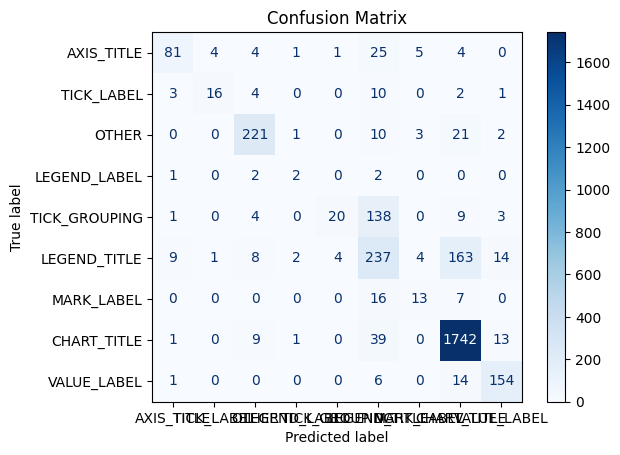

In [130]:
# Confusion Matrix
cm_econbiz = confusion_matrix(
    df_econbiz_dataset_ordered_wpred["role"],
    df_econbiz_dataset_ordered_wpred["predicted_role"],
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_econbiz,
    display_labels=labels,
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

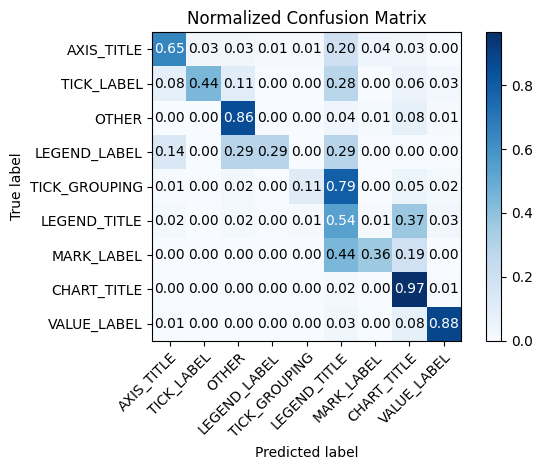

In [131]:
cm_econbiz_normalized = (
    cm_econbiz.astype("float") / cm_econbiz.sum(axis=1)[:, np.newaxis]
)

fig, ax = plt.subplots()
im = ax.imshow(cm_econbiz_normalized, interpolation="nearest", cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(cm_econbiz.shape[1]),
    yticks=np.arange(cm_econbiz.shape[0]),
    xticklabels=labels,
    yticklabels=labels,
    title="Normalized Confusion Matrix",
    ylabel="True label",
    xlabel="Predicted label",
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

fmt = ".2f"
thresh = cm_econbiz_normalized.max() / 2.0
for i in range(cm_econbiz.shape[0]):
    for j in range(cm_econbiz.shape[1]):
        ax.text(
            j,
            i,
            format(cm_econbiz_normalized[i, j], fmt),
            ha="center",
            va="center",
            color="white" if cm_econbiz_normalized[i, j] > thresh else "black",
        )
fig.tight_layout()
plt.show()

In [132]:
econbiz_accuracy = accuracy_score(
    df_econbiz_dataset_ordered_wpred["role"],
    df_econbiz_dataset_ordered_wpred["predicted_role"],
)
econbiz_precision_macro = precision_score(
    df_econbiz_dataset_ordered_wpred["role"],
    df_econbiz_dataset_ordered_wpred["predicted_role"],
    average="macro",
)
econbiz_precision_micro = precision_score(
    df_econbiz_dataset_ordered_wpred["role"],
    df_econbiz_dataset_ordered_wpred["predicted_role"],
    average="micro",
)
econbiz_recall_macro = recall_score(
    df_econbiz_dataset_ordered_wpred["role"],
    df_econbiz_dataset_ordered_wpred["predicted_role"],
    average="macro",
)
econbiz_recall_micro = recall_score(
    df_econbiz_dataset_ordered_wpred["role"],
    df_econbiz_dataset_ordered_wpred["predicted_role"],
    average="micro",
)
econbiz_f1_macro = f1_score(
    df_econbiz_dataset_ordered_wpred["role"],
    df_econbiz_dataset_ordered_wpred["predicted_role"],
    average="macro",
)
econbiz_f1_micro = f1_score(
    df_econbiz_dataset_ordered_wpred["role"],
    df_econbiz_dataset_ordered_wpred["predicted_role"],
    average="micro",
)

print("Accuracy:", econbiz_accuracy)
print("Precision (macro):", econbiz_precision_macro)
print("Precision (micro):", econbiz_precision_micro)
print("Recall (macro):", econbiz_recall_macro)
print("Recall (micro):", econbiz_recall_micro)
print("F1 Score (macro):", econbiz_f1_macro)
print("F1 Score (micro):", econbiz_f1_micro)

Accuracy: 0.8126838836220988
Precision (macro): 0.697970764830038
Precision (micro): 0.8126838836220988
Recall (macro): 0.5657156389748432
Recall (micro): 0.8126838836220988
F1 Score (macro): 0.5953198628619663
F1 Score (micro): 0.8126838836220988


## chimer

In [133]:
chimer_preds = []
with open("./datasets/eval_test_results/predictions_chimer.txt", "r") as f:
    for line in f:
        i, list_str = line.split(":", 1)
        items = ast.literal_eval(list_str.strip())
        chimer_preds.extend(items)
print(len(chimer_preds))

1587


In [134]:
df_chimer_dataset_ordered_wpred = pd.read_csv(
    "./datasets/eval_test_results/chimer_dataset_ordered_wpred.csv"
)
df_chimer_dataset_ordered_wpred["predicted_role"] = chimer_preds
df_chimer_dataset_ordered_wpred.head()

,role,bbox,id,predicted_role
0,AXIS_TITLE,"[55, 40, 74, 71]",0,AXIS_TITLE
1,TICK_LABEL,"[55, 83, 95, 130]",0,TICK_LABEL
2,TICK_LABEL,"[55, 172, 92, 218]",0,TICK_LABEL
3,TICK_LABEL,"[54, 260, 93, 306]",0,TICK_LABEL
4,TICK_LABEL,"[53, 345, 91, 392]",0,TICK_LABEL


In [135]:
df_chimer_dataset_ordered_wpred["role"].value_counts()

role
TICK_LABEL       1183
AXIS_TITLE        140
VALUE_LABEL       111
CHART_TITLE        67
LEGEND_LABEL       55
OTHER              25
TICK_GROUPING       5
LEGEND_TITLE        1
Name: count, dtype: int64

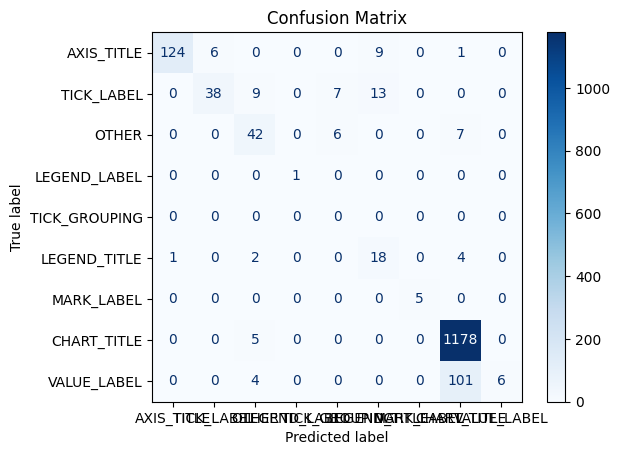

In [136]:
# Confusion Matrix
cm_chimer = confusion_matrix(
    df_chimer_dataset_ordered_wpred["role"],
    df_chimer_dataset_ordered_wpred["predicted_role"],
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_chimer,
    display_labels=labels,
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

/tmp/ipykernel_190391/1111531478.py:1: RuntimeWarning: invalid value encountered in divide
  cm_chimer_normalized = cm_chimer.astype("float") / cm_chimer.sum(axis=1)[:, np.newaxis]


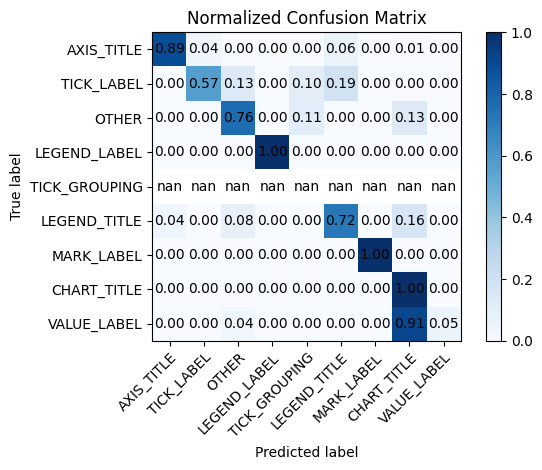

In [137]:
cm_chimer_normalized = cm_chimer.astype("float") / cm_chimer.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
im = ax.imshow(cm_chimer_normalized, interpolation="nearest", cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(cm_chimer.shape[1]),
    yticks=np.arange(cm_chimer.shape[0]),
    xticklabels=labels,
    yticklabels=labels,
    title="Normalized Confusion Matrix",
    ylabel="True label",
    xlabel="Predicted label",
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

fmt = ".2f"
thresh = cm_chimer_normalized.max() / 2.0
for i in range(cm_chimer.shape[0]):
    for j in range(cm_chimer.shape[1]):
        ax.text(
            j,
            i,
            format(cm_chimer_normalized[i, j], fmt),
            ha="center",
            va="center",
            color="white" if cm_chimer_normalized[i, j] > thresh else "black",
        )
fig.tight_layout()
plt.show()

In [138]:
chimer_accuracy = accuracy_score(
    df_chimer_dataset_ordered_wpred["role"],
    df_chimer_dataset_ordered_wpred["predicted_role"],
)
chimer_precision_macro = precision_score(
    df_chimer_dataset_ordered_wpred["role"],
    df_chimer_dataset_ordered_wpred["predicted_role"],
    average="macro",
)
chimer_precision_micro = precision_score(
    df_chimer_dataset_ordered_wpred["role"],
    df_chimer_dataset_ordered_wpred["predicted_role"],
    average="micro",
)
chimer_recall_macro = recall_score(
    df_chimer_dataset_ordered_wpred["role"],
    df_chimer_dataset_ordered_wpred["predicted_role"],
    average="macro",
)
chimer_recall_micro = recall_score(
    df_chimer_dataset_ordered_wpred["role"],
    df_chimer_dataset_ordered_wpred["predicted_role"],
    average="micro",
)
chimer_f1_macro = f1_score(
    df_chimer_dataset_ordered_wpred["role"],
    df_chimer_dataset_ordered_wpred["predicted_role"],
    average="macro",
)
chimer_f1_micro = f1_score(
    df_chimer_dataset_ordered_wpred["role"],
    df_chimer_dataset_ordered_wpred["predicted_role"],
    average="micro",
)

print("Accuracy:", chimer_accuracy)
print("Precision (macro):", chimer_precision_macro)
print("Precision (micro):", chimer_precision_micro)
print("Recall (macro):", chimer_recall_macro)
print("Recall (micro):", chimer_recall_micro)
print("F1 Score (macro):", chimer_f1_macro)
print("F1 Score (micro):", chimer_f1_micro)

Accuracy: 0.8897290485192186
Precision (macro): 0.7661696301360978
Precision (micro): 0.8897290485192186
Recall (macro): 0.6651491488690111
Recall (micro): 0.8897290485192186
F1 Score (macro): 0.6607996307604306
F1 Score (micro): 0.8897290485192186


/home/nassimb/.virtualenvs/text-role-class/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


# Push model to huggingface

In [139]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): Traceback (most recent call last):
  File "/home/nassimb/.virtualenvs/t